In [52]:
!python -m pip install --quiet pandas scikit-learn numpy matplotlib seaborn geopy folium tqdm



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Cargar Dataset

In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
ruta = 'src/athlete_events.csv'

print("Cargando dataset ...")
df = pd.read_csv(ruta)
print("Dataset cargado correctamente.")


Cargando dataset ...
Dataset cargado correctamente.


Mostrar dataset

In [54]:
print(df.head())

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's

<h1>Quitar las columnas inecesarias</h1>

Las columnas ['ID'] y ['Name'] no nos aportan nada.

La información de la columna ['Games'] la podemos sacar de ['Year'] y ['Season'].

La información de la columna ['Event'] la reducimos a la de la columna ['Sport'] para tener menos categorías.

Eliminamos la columna ['Team'] y nos quedamos con la columna ['NOC'] para no tener datos similares / duplicados.

In [55]:
df.drop(columns=["ID", "Name", "Games", "Event", "Team"], inplace=True)
print(df.head())

  Sex   Age  Height  Weight  NOC  Year  Season       City          Sport Medal
0   M  24.0   180.0    80.0  CHN  1992  Summer  Barcelona     Basketball   NaN
1   M  23.0   170.0    60.0  CHN  2012  Summer     London           Judo   NaN
2   M  24.0     NaN     NaN  DEN  1920  Summer  Antwerpen       Football   NaN
3   M  34.0     NaN     NaN  DEN  1900  Summer      Paris     Tug-Of-War  Gold
4   F  21.0   185.0    82.0  NED  1988  Winter    Calgary  Speed Skating   NaN


<h2>Observamos el número de valores NULL por columna.</h2>

In [56]:
df.isnull().sum()

Sex            0
Age         9474
Height     60171
Weight     62875
NOC            0
Year           0
Season         0
City           0
Sport          0
Medal     231333
dtype: int64

<h2> Eliminamos los valores nulos y transformarlos </h2

In [57]:
print("Número de filas:", len(df))
df = df.dropna(subset=['Height'])
df = df.dropna(subset=['Weight'])
df = df.dropna(subset=['Age'])
print("Número de filas tras eliminar nulos:", len(df))

df['Medal'] = df['Medal'].fillna('No Medal')


Número de filas: 271116
Número de filas tras eliminar nulos: 206165


<h2> Visualizar las categorias </h2>

En la columna de Sex | Medal | Season

In [58]:
print("\nValores únicos en las siguientes columnas:")
print("['Medal'] => ", df['Medal'].unique())



Valores únicos en las siguientes columnas:
['Medal'] =>  ['No Medal' 'Bronze' 'Gold' 'Silver']


<h2> Codificación de las variables categoriques </h2>

In [59]:
# from sklearn.preprocessing import LabelEncoder

# Se ha usado un "Label Encoder" manual ya que la codificación mediante LabelEncoder()
# se hacía de forma alfabética, lo que nos perjudica si queremos ordenar las medallas
# de peor a mejor resultado (No Medal -> Bronze -> Silver -> Gold)

# Visualizamos los diferentes valores en la columna ['Medal']
print(df['Medal'].unique())

# Realizamos un diccionario con los valores actuales y los numéricos a los que queremos codificar
medal_map = {'No Medal': 0, 'Bronze': 1, 'Silver': 2, 'Gold': 3}

# Codificamos las variables categóricas a numéricas
df['Medal'] = df['Medal'].map(medal_map)

# Comprobar resultado
print(df['Medal'].unique())

# 0 => No Medal
# 1 => Bronze
# 2 => Silver
# 3 => Gold

['No Medal' 'Bronze' 'Gold' 'Silver']
[0 1 3 2]


## Binarización de las columnas numéricas

In [60]:
df['Sex_Male'] = (df['Sex'] == "M").astype(int)
df['Sesion_Winter'] = (df['Season'] == "Winter").astype(int)

print(df[['Sex_Male', 'Sesion_Winter']].head())

df.drop(columns=["Sex", "Season"], inplace=True)

   Sex_Male  Sesion_Winter
0         1              0
1         1              0
4         0              1
5         0              1
6         0              1


## Realizar escalado entre 0 y 1 las siguientes columnas numéricas

#### Age | Weight | Height

In [61]:
scaler = MinMaxScaler()
df[['Age', 'Weight', 'Height']] = scaler.fit_transform(df[['Age', 'Weight', 'Height']])

print(df[['Age', 'Weight', 'Height']].head())

        Age    Weight    Height
0  0.216667  0.291005  0.535354
1  0.200000  0.185185  0.434343
4  0.166667  0.301587  0.585859
5  0.166667  0.301587  0.585859
6  0.233333  0.301587  0.585859


In [62]:
df.head()

,Age,Height,Weight,NOC,Year,City,Sport,Medal,Sex_Male,Sesion_Winter
0,0.216667,0.535354,0.291005,CHN,1992,Barcelona,Basketball,0,1,0
1,0.200000,0.434343,0.185185,CHN,2012,London,Judo,0,1,0
4,0.166667,0.585859,0.301587,NED,1988,Calgary,Speed Skating,0,0,1
5,0.166667,0.585859,0.301587,NED,1988,Calgary,Speed Skating,0,0,1
6,0.233333,0.585859,0.301587,NED,1992,Albertville,Speed Skating,0,0,1


In [63]:
df.tail()

,Age,Height,Weight,NOC,Year,City,Sport,Medal,Sex_Male,Sesion_Winter
271111,0.300000,0.525253,0.338624,POL,1976,Innsbruck,Luge,0,1,1
271112,0.266667,0.494949,0.179894,POL,2014,Sochi,Ski Jumping,0,1,1
271113,0.266667,0.494949,0.179894,POL,2014,Sochi,Ski Jumping,0,1,1
271114,0.316667,0.585859,0.375661,POL,1998,Nagano,Bobsleigh,0,1,1
271115,0.383333,0.585859,0.375661,POL,2002,Salt Lake City,Bobsleigh,0,1,1


## GRAFICOS

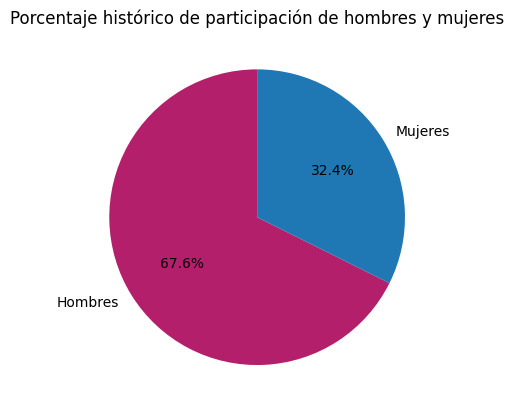

In [64]:
import matplotlib.pyplot as plt

# Mapear los números binarios con sus nombres
sex_map = {0: 'Mujeres', 1: 'Hombres'}

# Contar los valores
counts = df['Sex_Male'].value_counts()

# Grafica pie chart
counts.plot(
    kind='pie',
    labels=[sex_map[i] for i in counts.index],
    autopct='%1.1f%%',
    colors=["#b41f6c", "#1f77b4"],
    startangle=90
)

plt.title("Porcentaje histórico de participación de hombres y mujeres")
plt.ylabel("")  # Eliminar etiqueta
plt.show()

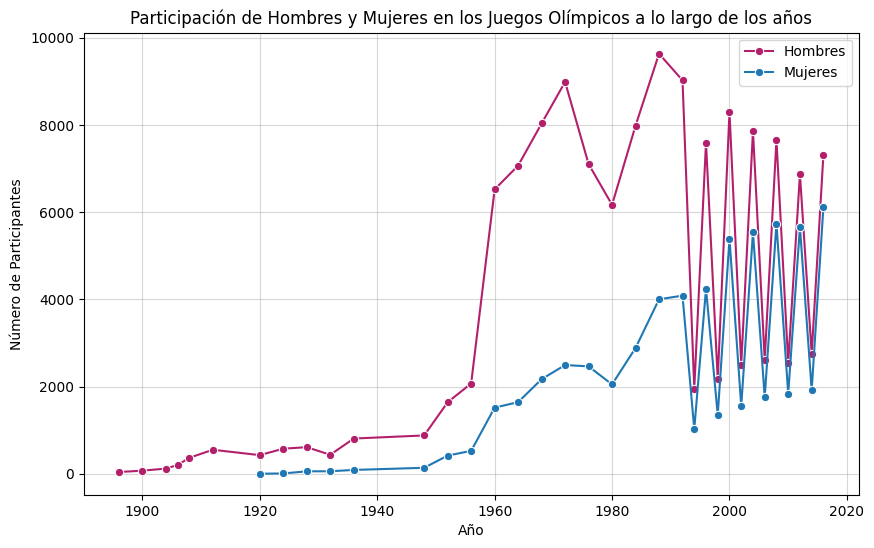

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

participacion = df.groupby(['Year', 'Sex_Male']).size().reset_index(name='Participantes')

# Mapear los números binarios con sus nombres
sex_map = {0: 'Mujeres', 1: 'Hombres'}

# Crear columna con el nombre de los sexos a partir del mapeo
participacion['Sexo'] = participacion['Sex_Male'].map(sex_map)

# Gráfica de puntos
plt.figure(figsize=(10,6))
sns.lineplot(
    data=participacion,
    x='Year',
    y='Participantes',
    hue='Sexo',
    marker='o',
    palette=["#b41f6c", "#1f77b4"]
)

# Estilo y etiquetas
plt.title('Participación de Hombres y Mujeres en los Juegos Olímpicos a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Número de Participantes')
plt.grid(True, alpha=0.5)
plt.legend(title='')
plt.show()

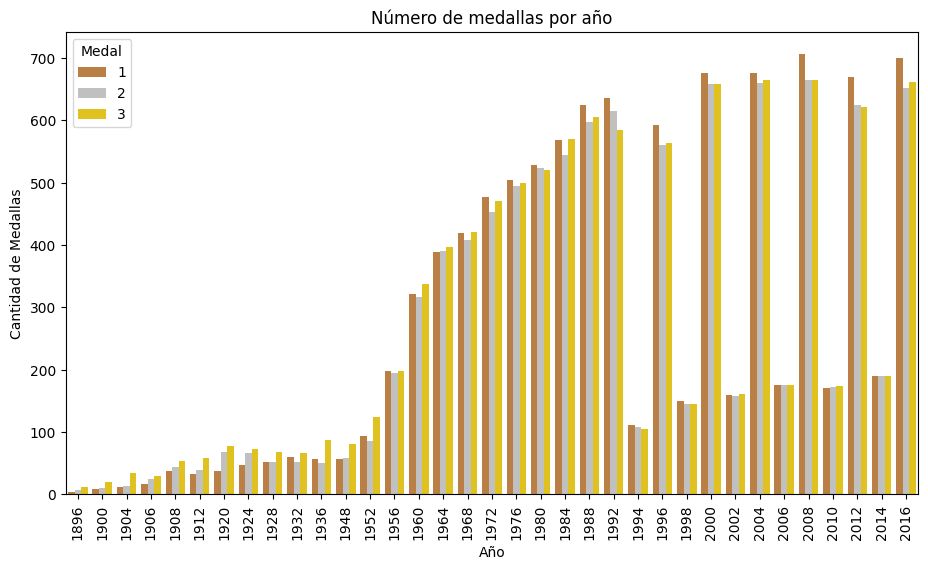

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,6))
sns.countplot(
    x='Year',
    hue='Medal',
    data=df[df['Medal'] != 0],
    palette={1: '#CD7F32', 2: '#C0C0C0', 3: '#FFD700'}
)

plt.xticks(rotation=90)
plt.title("Número de medallas por año")
plt.ylabel("Cantidad de Medallas")
plt.xlabel("Año")
plt.show()

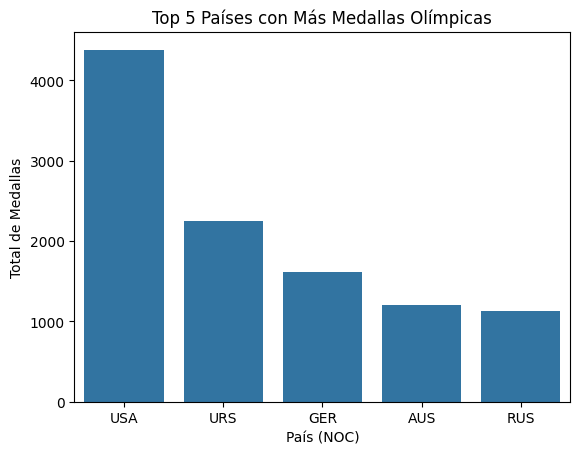

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    data=df[df['Medal'] != 0],
    x='NOC',
    order=df[df['Medal'] != 0]['NOC'].value_counts().head(5).index
)
plt.title('Top 5 Países con Más Medallas Olímpicas')
plt.xlabel('País (NOC)')
plt.ylabel('Total de Medallas')
plt.show()

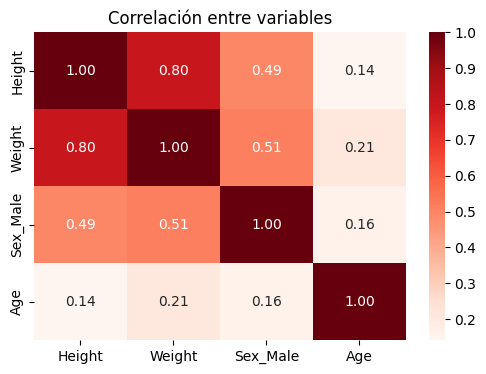

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Height', 'Weight', 'Sex_Male', 'Age']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
plt.title("Correlación entre variables")
plt.show()

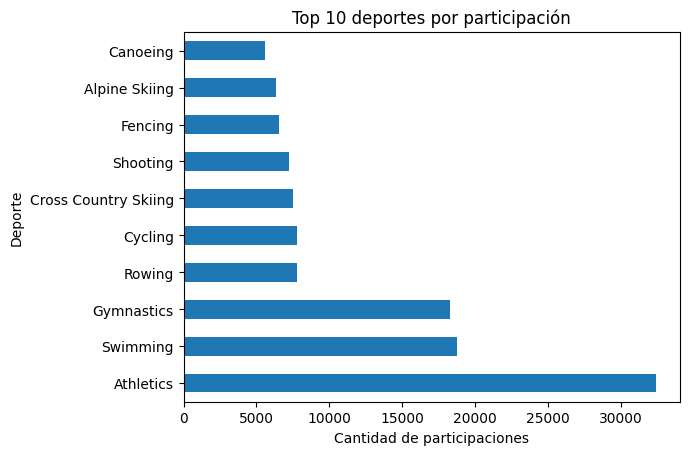

In [69]:
import matplotlib.pyplot as plt

df['Sport'].value_counts().head(10).plot(kind='barh')
plt.title("Top 10 deportes por participación")
plt.xlabel("Cantidad de participaciones")
plt.ylabel("Deporte")
plt.show()

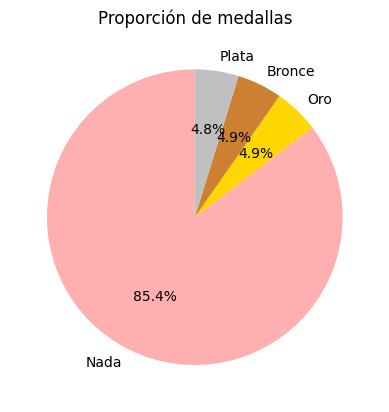

In [70]:
import matplotlib.pyplot as plt

# Diccionario de nombres
medal_map = {0: 'Nada', 1: 'Bronce', 2: 'Plata', 3: 'Oro'}

# Contar los valores
counts = df['Medal'].value_counts()

# Graficar pie chart con etiquetas
counts.plot(
    kind='pie',
    labels=[medal_map[i] for i in counts.index],  # mapeamos los números a nombres
    autopct='%1.1f%%',
    colors=["#FFAFAF", "#FFD700", '#CD7F32',  '#C0C0C0'],
    startangle=90
)

plt.title("Proporción de medallas")
plt.ylabel("")  # eliminar etiqueta del eje y
plt.show()


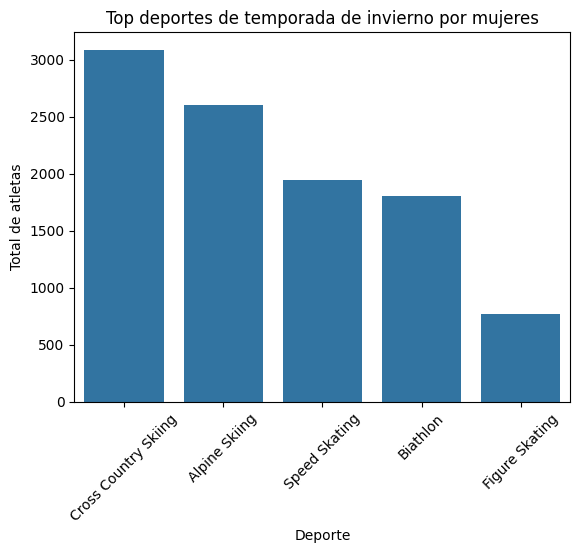

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    data=df[(df['Sesion_Winter'] == 1) & (df['Sex_Male'] == 0)],
    x='Sport',
    order=df[(df['Sesion_Winter'] == 1) & (df['Sex_Male'] == 0)]['Sport'].value_counts().head(5).index
)

plt.title('Top deportes de temporada de invierno por mujeres')
plt.xlabel('Deporte')
plt.ylabel('Total de atletas')
plt.xticks(rotation=45)
plt.show()


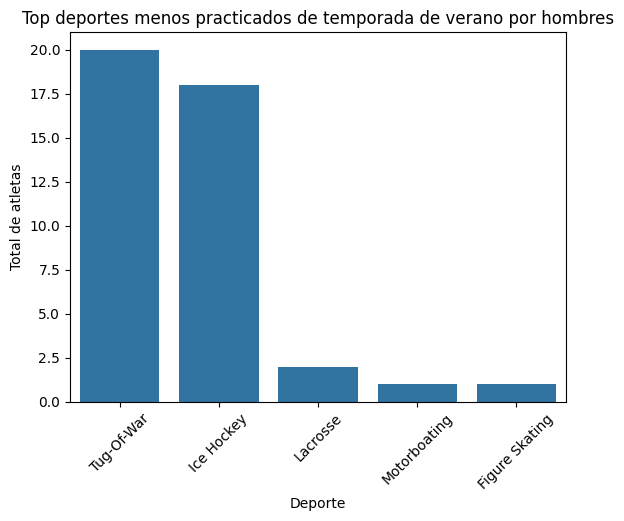

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    data=df[(df['Sesion_Winter'] == 0) & (df['Sex_Male'] == 1)],
    x='Sport',
    order=df[(df['Sesion_Winter'] == 0) & (df['Sex_Male'] == 1)]['Sport'].value_counts().tail(5).index
)

plt.title('Top deportes menos practicados de temporada de verano por hombres')
plt.xlabel('Deporte')
plt.ylabel('Total de atletas')
plt.xticks(rotation=45)
plt.show()

In [75]:
import pandas as pd
from geopy.geocoders import Nominatim
from tqdm import tqdm
import time
import folium
from folium.plugins import HeatMap
from IPython.display import display

# --- 1️⃣ Inicializar geolocalizador ---
geolocator = Nominatim(user_agent="geoapi")

def get_coordinates(city):
    """Devuelve (lat, lon) de una ciudad, con pausa para evitar bloqueos."""
    try:
        if pd.isna(city):
            return pd.Series({'latitude': None, 'longitude': None})
        location = geolocator.geocode(city)
        time.sleep(1)
        if location:
            return pd.Series({'latitude': location.latitude, 'longitude': location.longitude})
        else:
            return pd.Series({'latitude': None, 'longitude': None})
    except Exception as e:
        print(f"Error con {city}: {e}")
        return pd.Series({'latitude': None, 'longitude': None})

# --- 2️⃣ Geocodificar solo las ciudades únicas ---
tqdm.pandas()
unique_cities = df[['City']].drop_duplicates().reset_index(drop=True)

# Aseguramos columnas
coords = unique_cities['City'].progress_apply(get_coordinates)
unique_cities = pd.concat([unique_cities, coords], axis=1)

# --- 3️⃣ Unir de nuevo al dataframe original ---
df = df.merge(unique_cities, on='City', how='left')

# --- 4️⃣ Agrupar y contar repeticiones ---
df_grouped = df.groupby(['City', 'latitude', 'longitude']).size().reset_index(name='count')

# --- 5️⃣ Crear mapa ---
m = folium.Map(location=[df_grouped['latitude'].mean(), df_grouped['longitude'].mean()], zoom_start=4)
heat_data = [[row['latitude'], row['longitude'], row['count']] for _, row in df_grouped.iterrows()]
HeatMap(heat_data, radius=25, blur=15, max_zoom=5).add_to(m)

from IPython.display import display
display(m)


100%|██████████| 42/42 [01:03<00:00,  1.50s/it]
